In [1]:
cd /home/ubuntu/DistMEC/

/home/ubuntu/DistMEC


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from classes.User import *
from classes.solver import *
from classes.Server import *
from classes.distributed_utils import *

from tqdm import tqdm, tqdm_notebook
from time import sleep
import pickle
import os

In [3]:
# Fix P
def fix_P(user):
    P = user.P
    
    for i in range(user.P.shape[1]):
        tot = np.sum(user.P[i])
        if tot != 1.0:
            user.P[i] = user.P[i]/tot
        
    return


def obtain_w_stationary(Users, num_users, num_svrs):
    
    w_curr = np.zeros([num_users,num_svrs])
    for i in range(num_users):
        w_curr[i] = Users[i].stationary_reward_scale
    
    return w_curr

def extract_centralized_case(Users, num_users, num_svrs):
    
    rewards_record = np.zeros([num_users,num_svrs])
    pulls_record = np.zeros([num_users,num_svrs])
    ucb = np.zeros([num_users,num_svrs])
    
    for i in range(num_users):
        rewards_record[i] = Users[i].param_summed
        pulls_record[i] = Users[i].pulls
        ucb[i] = Users[i].ucb_raw 
    
    return rewards_record, pulls_record, ucb

In [4]:
# System Parameters
T = 10000
num_users = 10
num_svrs = 16
num_locs = 16
mu = np.random.uniform(low=0, high = 1, size = [num_users, num_svrs])
ceiling = 40
# w = np.random.uniform(low=0, high=1, size= [num_users, num_svrs])
space_1d_dim = 10 #4 for small, 10 for big

num_explore = 1
trials = 1

# result dictionaries
result_dicts = []
performance_list = []
user_dicts = []

save_name = 'results/22_06_16_ceiling_20/'
isExist = os.path.exists(save_name)
if not isExist:
  # Create a new directory because it does not exist 
    os.makedirs(save_name)

for tri in range(trials):
    
    print("trial:", tri)
    result_dict = {}
    user_dict = {}
    
    # Generate visitng locations and server locations
    usr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_locs)
    svr_locs = gen_eq_locs(space_1d=space_1d_dim, nums=num_svrs)

    # Create Users
    Users_w = []
    for i in range(num_users):
        Users_w += [User(usr_locs,svr_locs,mu[i],i,
                      max_dist = 4, threshold_dist = 4, self_weight = 1 - 0.95, P = None, ceiling = 1,
                      sticky_mode = False, kick_mode=True)]
            
    # Create Servers
    Servers = []
    for i in range(num_svrs):
        Servers += [Server(svr_locs[i],mu,i)]

    # Recorded Values - reservation
    regret_w = np.zeros(T)
    collision_count_w = np.zeros(T)
    optimal_reward = np.zeros(T)

    # Explore rounds are common/shared across all users
    explore_rounds(Users_w, num_users, Servers, mu, regret_w, collision_count_w, optimal_reward,
                   usr_move_flag = True, rounds=num_explore)
    
    # Distributed - true w learning
    Users_s = copy.deepcopy(Users_w)
    regret_s = copy.deepcopy(regret_w)
    collision_count_s = copy.deepcopy(collision_count_w)
    for u in Users_s:
        u.sticky_mode = True
        u.kick_mode = True #false
        u.ceiling = ceiling
        u.expected_time_true = u.get_expected_time()
        
    # Centralized - true w learning
    rewards_record_ct, pulls_record_ct, ucb_ct = extract_centralized_case(Users_w, num_users, num_svrs)
    regret_ct = copy.deepcopy(regret_w)
    
    # Centralized - stationary w learning
    rewards_record_cs, pulls_record_cs, ucb_cs = extract_centralized_case(Users_w, num_users, num_svrs)
    regret_cs = copy.deepcopy(regret_w)
    
    # Centralized - stationary w, known mu
    w_stat = obtain_w_stationary(Users_w, num_users, num_svrs)
    optimal_stat_arms = offline_optimal_action(w_stat,mu)[0]
    regret_cst = copy.deepcopy(regret_w)
    
    round_start = ((num_svrs)*num_explore)+1
    for (zzz,t) in zip(tqdm_notebook(range(T-round_start)),range(round_start, T)):
        w = obtain_w(Users_w, len(Users_w), len(Servers))
        optimal = offline_optimal_action(w, mu)
        optimal_reward[t] = optimal[1]
        
        # Distributed solution 
        play_round(Users_w, Servers, mu, regret_w, collision_count_w, 
                   usr_move_flag = True, debugger = False, reservation_mode = True, optimal =optimal)
        play_round(Users_s, Servers, mu, regret_s, collision_count_s, 
                   usr_move_flag = False, debugger=False, reservation_mode = True, optimal=optimal)
        copy_usr_loc(Users_w, Users_s)
        
        # Centralized Solution -  true w learning
        ucb_ct = update_ucb(rewards_record_ct, pulls_record_ct, ucb_ct, t, 1)
        arms = offline_optimal_action(w, ucb_ct)[0]
        rewards_record_ct, pulls_record_ct = pull_super_arm(arms, mu, rewards_record_ct, pulls_record_ct)
        regret_ct[t] = optimal[1] - expected_reward(arms, mu, w)
        
        # Centralized Solution -  stationary w learning
        ucb_cs = update_ucb(rewards_record_cs, pulls_record_cs, ucb_cs, t, 1)
        arms = offline_optimal_action(w_stat, ucb_cs)[0]
        rewards_record_cs, pulls_record_cs = pull_super_arm(arms, mu, rewards_record_cs, pulls_record_cs)
        regret_cs[t] = optimal[1] - expected_reward(arms, mu, w)
        
        # centralized solution - stationary w, known mu
        regret_cst[t] = optimal[1] - expected_reward(optimal_stat_arms, mu, w) 
        
    # Obtain reward values
    reward_w = optimal_reward - regret_w
    reward_s = optimal_reward - regret_s
    reward_cs = optimal_reward - regret_cs
    reward_cst = optimal_reward - regret_cst
    reward_ct = optimal_reward -regret_ct
    
    threshold = 1

    # reward[reward <=  0] = threshold
    reward_w[reward_w <= 0] = reward_s[reward_w <=  0]# threshold
    
    # Log results
    result_dict["reward_w"] = reward_w
    result_dict["reward_s"] = reward_s
    result_dict["reward_cs"] = reward_cs
    result_dict["reward_ct"] = reward_ct
    result_dict["reward_cst"] = reward_cst
    
    result_dict["regret_w"] = regret_w
    result_dict["regret_s"] = regret_s
    result_dict["regret_cs"] = regret_cs
    result_dict["regret_ct"] = regret_ct
    result_dict["regret_cst"] = regret_cst
    
    result_dict["collision_w"] = collision_count_w
    result_dict["collision_s"] = collision_count_s
    
    if np.cumsum(regret_w)[-1] > np.cumsum(regret_s)[-1]:
        performance_list += [1]
    else:
        performance_list += [0]

trial: 0


In [5]:
result_dicts += [result_dict]

In [6]:
performance_list

[1]

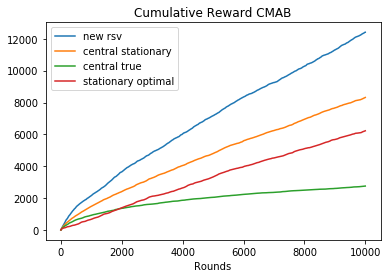

In [7]:
plot_idx = 0

# plt.plot(np.cumsum(result_dicts[plot_idx]['regret_w']), label = 'worst case')
plt.plot(np.cumsum(result_dicts[plot_idx]['regret_s']), label = 'new rsv')
plt.plot(np.cumsum(result_dicts[plot_idx]['regret_cs']), label = 'central stationary')
plt.plot(np.cumsum(result_dicts[plot_idx]['regret_ct']), label = 'central true')
plt.plot(np.cumsum(result_dicts[plot_idx]['regret_cst']), label = 'stationary optimal')

plt.title('Cumulative Reward CMAB')
plt.xlabel('Rounds')
plt.legend()

In [8]:
result_dicts[plot_idx]['regret_cst'][-50:]

array([0.89667116, 0.93320896, 0.91248433, 0.91248433, 0.59612862,
       0.59612862, 0.59612862, 0.59612862, 0.59612862, 0.59612862,
       0.59612862, 0.59612862, 0.76707526, 1.05982101, 1.05982101,
       0.62291878, 0.49241778, 0.49241778, 0.49241778, 0.61430837,
       0.61430837, 0.5038378 , 0.5038378 , 0.5038378 , 0.5038378 ,
       0.5038378 , 0.5038378 , 0.5038378 , 0.95718996, 0.95718996,
       1.11261268, 1.11261268, 0.99720926, 1.11261268, 0.98839473,
       0.92998046, 0.97821784, 0.97821784, 0.81528268, 1.01790031,
       1.01790031, 1.01790031, 0.75555039, 0.74538955, 0.65318201,
       0.65318201, 0.65318201, 0.65318201, 0.65318201, 0.47444574])